# Data


In [32]:
import os
import pandas as pd
import numpy as np
from ament_index_python.packages import get_package_share_directory


# Define the file path
oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_sin_response_4V_1s.csv",
)


# Define the target columns for X and Y data
x_columns = [
    "/effort_control/data.0",
    "/joint_states/joint0/position",
    "/joint_states/joint1/position",
    "/joint_states/joint0/velocity",
    "/joint_states/joint1/velocity",
]

# Define the starting index
starting_idx = 0
ending_idx = 2000

In [33]:
class CustomDataset:
    def __init__(self, csv_file, x_columns, starting_idx, ending_idx):
        self.time_col = "/joint_states/header/stamp"
        self.control_col = "/effort_control/data.0"
        self.x_columns = x_columns

        # Read only the necessary columns
        self.data = pd.read_csv(
            csv_file,
            skiprows=range(1, starting_idx),
            usecols=self.x_columns + [self.time_col],
            nrows=ending_idx - starting_idx
        )

        # Modify and preprocess data
        self.modify_data()
        self.remove_nan()
        self.normalize_data()

    def get_timestamp(self, idx):
        return self.data.iloc[idx][self.time_col]

    def __getitem__(self, idx):
        return self.data.iloc[idx][self.x_columns]

    def __len__(self):
        return len(self.data)

    def modify_data(self):
        last_value = 0.0
        for idx, row in self.data.iterrows():
            if np.isnan(row[self.control_col]):
                row[self.control_col] = last_value
            else:
                last_value = row[self.control_col]

    def remove_nan(self):
        self.data.dropna(inplace=True)

    def normalize_data(self):
        # Calculate the offset values based on the first row
        offset_values = self.data.iloc[0][self.x_columns + [self.time_col]]

        # Subtract the offset values from each corresponding column
        self.data[self.x_columns + [self.time_col]] -= offset_values


# Create the custom dataset
dataset = CustomDataset(oscillations_file, x_columns, starting_idx, ending_idx)

1016


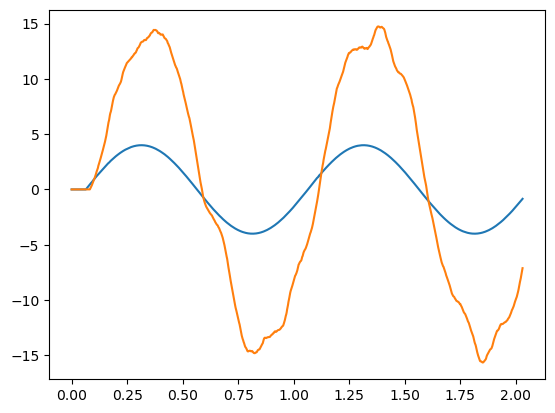

In [34]:
from matplotlib.pyplot import plot

V_setpoint = [x[0] for x in dataset]
velocity = [x[3] for x in dataset]
timestamps = [dataset.get_timestamp(idx) for idx in range(len(dataset))]

plot(timestamps, V_setpoint)
plot(timestamps, velocity)
print(len(timestamps))

# Simulation

In [35]:
import yaml
import os
from ament_index_python.packages import get_package_share_directory

pendulum_params_file = os.path.join(
    get_package_share_directory("furuta_pendulum_description"),
    "config",
    "pendulum_parameters.yaml",
)

with open(pendulum_params_file, "r") as file:
    pendulum_params = yaml.safe_load(file)["/**"]["ros__parameters"]

g = 9.80665

m1 = pendulum_params["m1"]
m2 = pendulum_params["m2"]

l1 = pendulum_params["l1"]
l2 = pendulum_params["l2"]

L1 = pendulum_params["L1"]
L2 = pendulum_params["L2"]

J1 = pendulum_params["J1"]
J2 = pendulum_params["J2"]

b1 = pendulum_params["b1"]
b2 = pendulum_params["b2"]

# b1 = 0.000868614247692284

J2_hat = J2 + m2 * l2 * l2
J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1

Kt = pendulum_params["Kt"]
Kemf = pendulum_params["Kemf"]
R = pendulum_params["R"]

In [36]:
import numpy as np
from scipy.integrate import odeint


class F_opt:
    def __init__(self, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R, V):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.L1 = L1
        self.L2 = L2
        self.J1 = J1
        self.J2 = J2
        self.b1 = b1
        self.b2 = b2
        self.J2_hat = J2 + m2 * l2 * l2
        self.J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1
        self.V = V

        self.Kemf = Kemf
        self.Kt = Kt
        self.R = R

    def __call__(self, y, t):
        # based on https://www.hindawi.com/journals/jcse/2011/528341/

        # theta1 = y[0]
        theta2 = y[1]
        dtheta1 = y[2]
        dtheta2 = y[3]

        vec11 = np.zeros((5, 1))
        vec11[0] = -self.J2_hat * self.b1
        vec11[1] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b2
        vec11[2] = -np.power(self.J2_hat, 2) * np.sin(2.0 * theta2)
        vec11[3] = (
            -0.5
            * self.J2_hat
            * self.m2
            * self.L1
            * self.l2
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec11[4] = self.J2_hat * self.m2 * self.L1 * self.l2 * np.sin(theta2)

        vec21 = np.zeros((5, 1))
        vec21[0] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b1
        vec21[1] = -self.b2 * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        vec21[2] = (
            self.m2
            * self.L1
            * self.l2
            * self.J2_hat
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec21[3] = (
            -0.5
            * np.sin(2.0 * theta2)
            * (self.J0_hat * self.J2_hat + np.power(self.J2_hat * np.sin(theta2), 2))
        )
        vec21[4] = (
            -0.5 * np.power(self.m2 * self.L1 * self.l2, 2) * np.sin(2.0 * theta2)
        )

        thetas_vec = np.zeros((5, 1))
        thetas_vec[0] = dtheta1
        thetas_vec[1] = dtheta2
        thetas_vec[2] = dtheta1 * dtheta2
        thetas_vec[3] = np.power(dtheta1, 2)
        thetas_vec[4] = np.power(dtheta2, 2)

        vec12 = np.zeros((3, 1))
        vec12[0] = self.J2_hat
        vec12[1] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec12[2] = 0.5 * np.power(self.m2 * self.l2, 2) * self.L1 * np.sin(2.0 * theta2)

        vec22 = np.zeros((3, 1))
        vec22[0] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec22[1] = self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2)
        vec22[2] = (
            -self.m2
            * self.l2
            * np.sin(theta2)
            * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        )

        # tau1 = (
        #     (self.Kt / self.R)
        #     * (self.V - self.Kemf * dtheta1)
        #     * np.power((7.7 - dtheta1), 0.5)
        # )
        # - self.b1 * np.power(dtheta1/5.0,3)

        tau1 = (self.Kt / self.R) * (self.V - self.Kemf * dtheta1)
        # - self.b1 * dtheta1

        tau2 = 0.0
        # tau2 = - self.b2 * dtheta2

        taus_g_vec = np.zeros((3, 1))
        taus_g_vec[0] = tau1
        taus_g_vec[1] = tau2
        taus_g_vec[2] = g

        denominator = (
            self.J0_hat * self.J2_hat
            + np.power(self.J2_hat * np.sin(theta2), 2)
            - np.power(self.m2 * self.L1 * self.l2 * np.cos(theta2), 2)
        )

        numerator1 = (vec11.T @ thetas_vec + vec12.T @ taus_g_vec)[0][0]
        numerator2 = (vec21.T @ thetas_vec + vec22.T @ taus_g_vec)[0][0]

        dy = np.zeros(4)
        dy[0] = dtheta1
        dy[1] = dtheta2
        dy[2] = numerator1 / denominator
        dy[3] = numerator2 / denominator

        return dy


def create_trajectory(timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R):
    result = []
    y_previous = [0, 0, 0, 0]
    for i in range(len(timestamps) - 1):
        f_opt = F_opt(
            m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R, V_setpoint[i]
        )
        # Integrate from previous time to current time
        t_span = [timestamps[i], timestamps[i + 1]]
        y_integrated = odeint(f_opt, y_previous, t_span)[-1]
        result.append(y_integrated)
        y_previous = y_integrated

    result.append(y_integrated)
    return np.array(result)

-1.6214399263375803
1016
1016


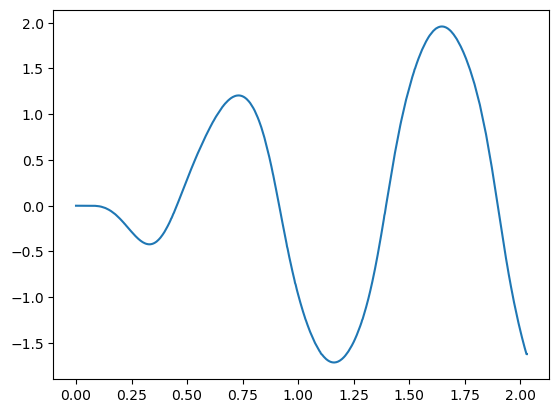

In [37]:
from matplotlib.pyplot import plot

s = create_trajectory(timestamps, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R])
traj = [x[1] for x in s]
plot(timestamps, traj)
print(traj[-1])
print(len(timestamps))
print(len(traj))

# Comparison


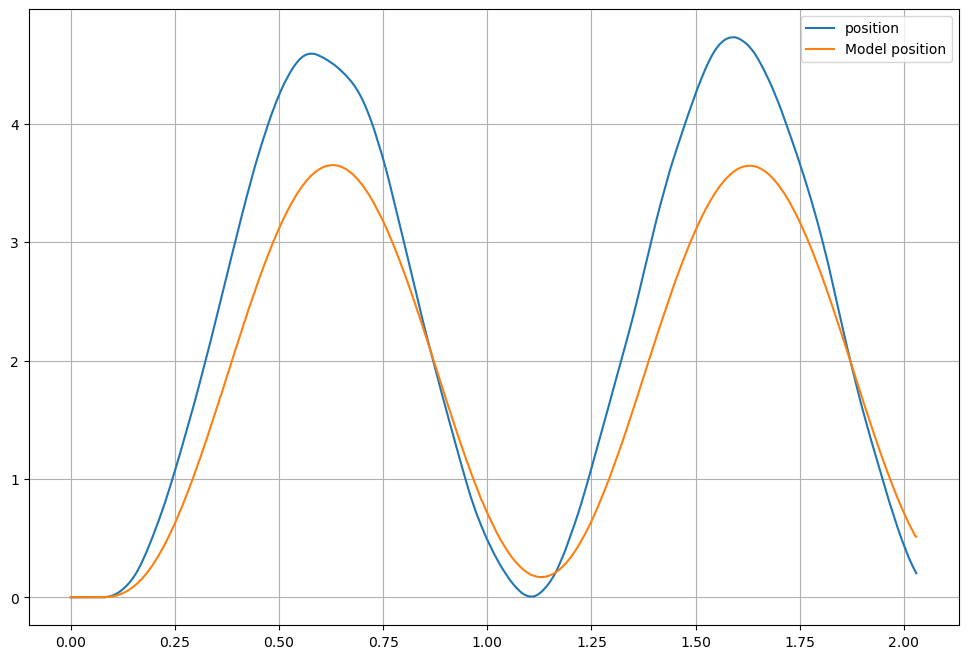

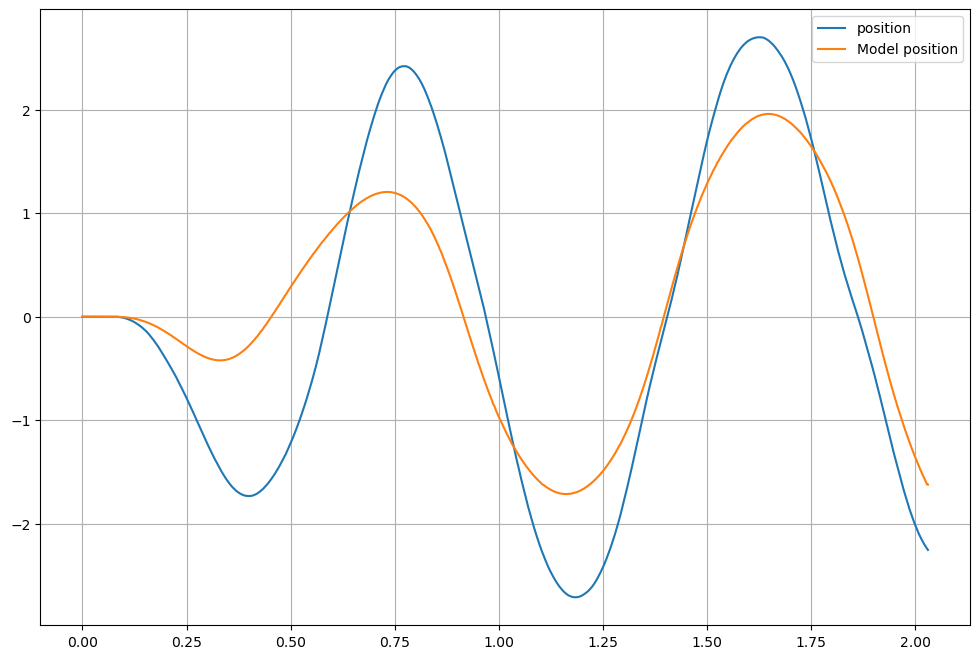

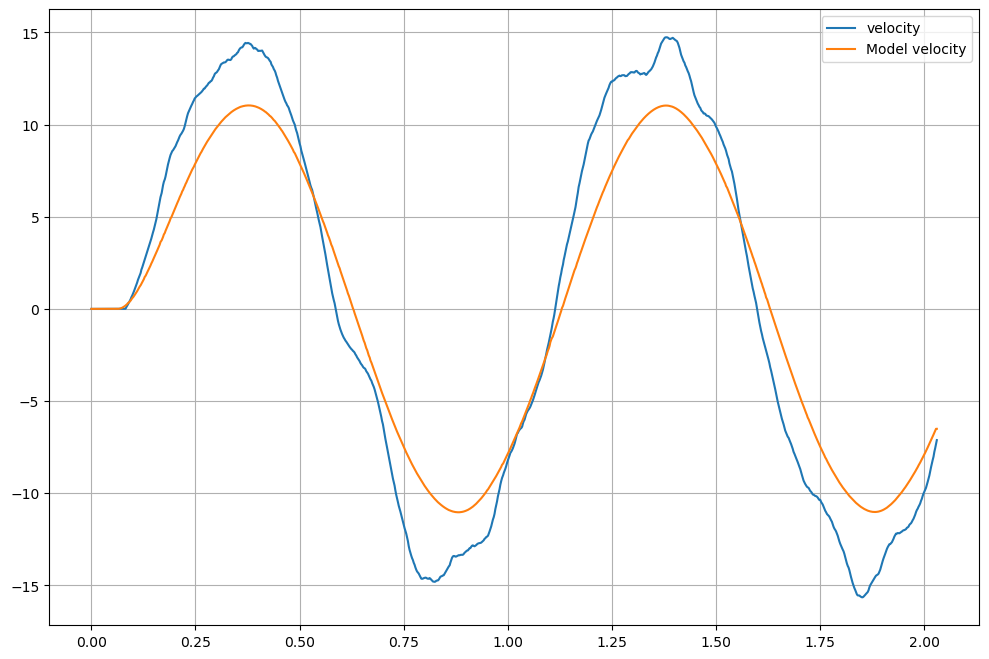

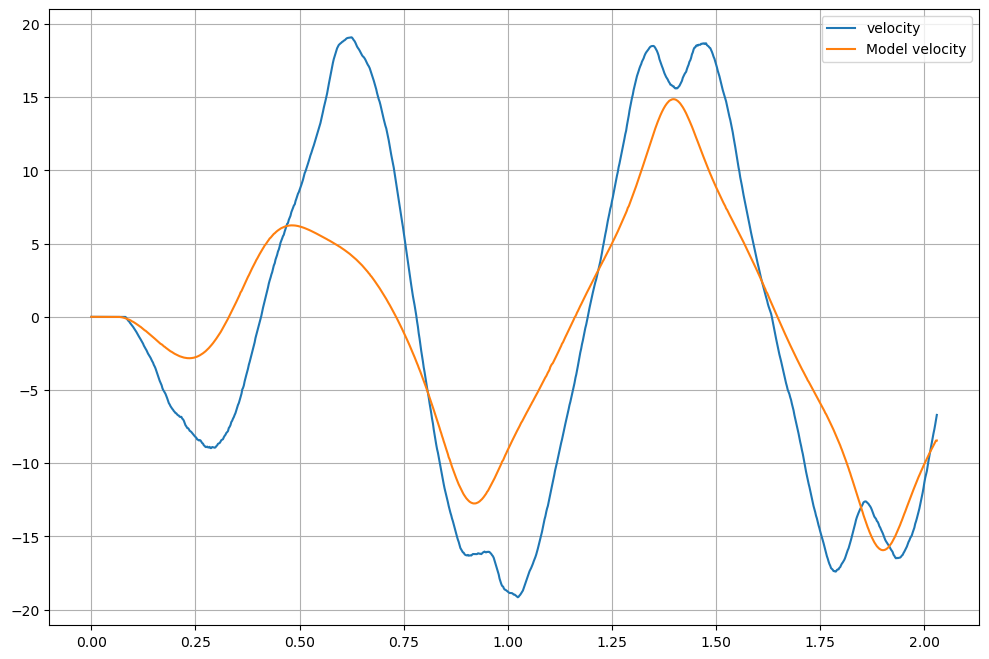

In [38]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i+1] for x in dataset], label=x_columns[i+1].split("/")[-1])
    plot(timestamps, [x[i] for x in s], label="Model " + x_columns[i+1].split("/")[-1])
    plt.legend()
    plt.grid(True)
    plt.show()

# Optimization

Optimized parameters: [4.24763713e-02 8.56631902e-03 5.68138405e-02 1.82074868e-02
 1.38475864e-01 1.29000000e-01 9.38784864e-04 1.99037497e-05
 1.63243891e-02 1.79057030e-09 1.49395231e-01 4.30979322e-04
 3.13017256e+00]


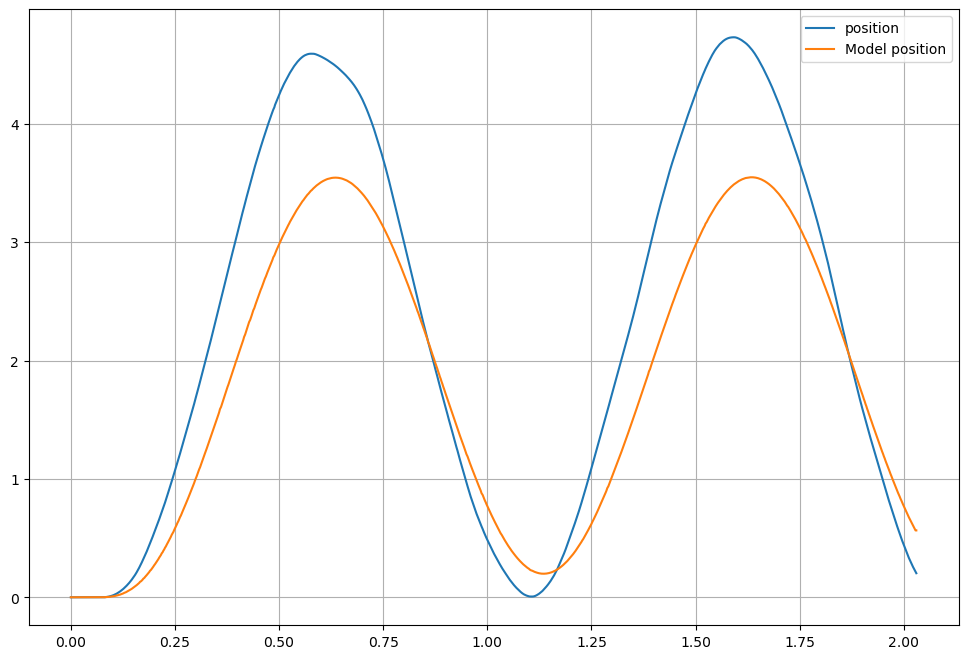

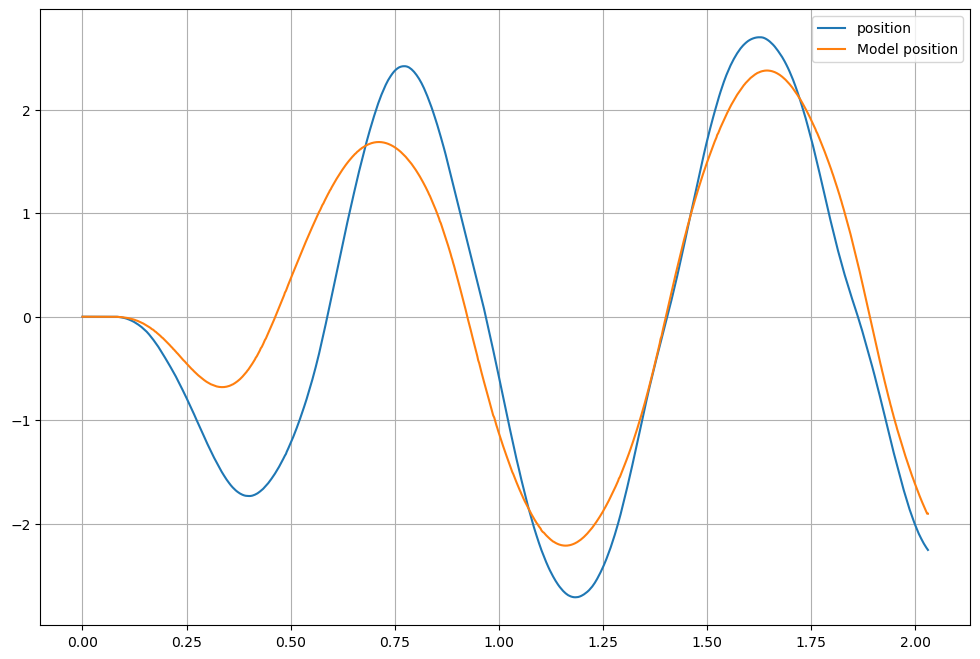

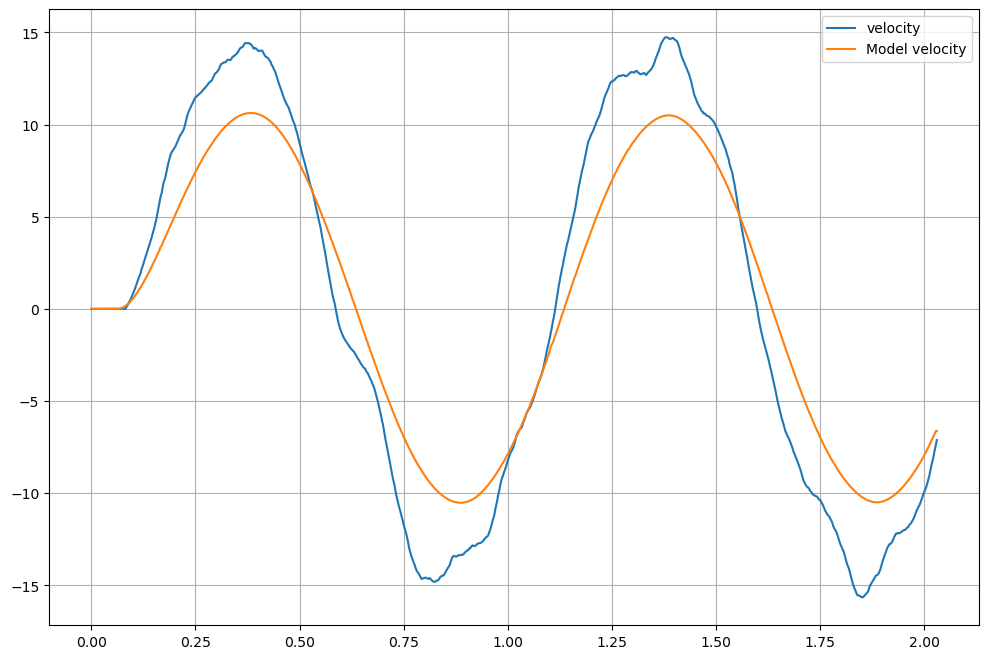

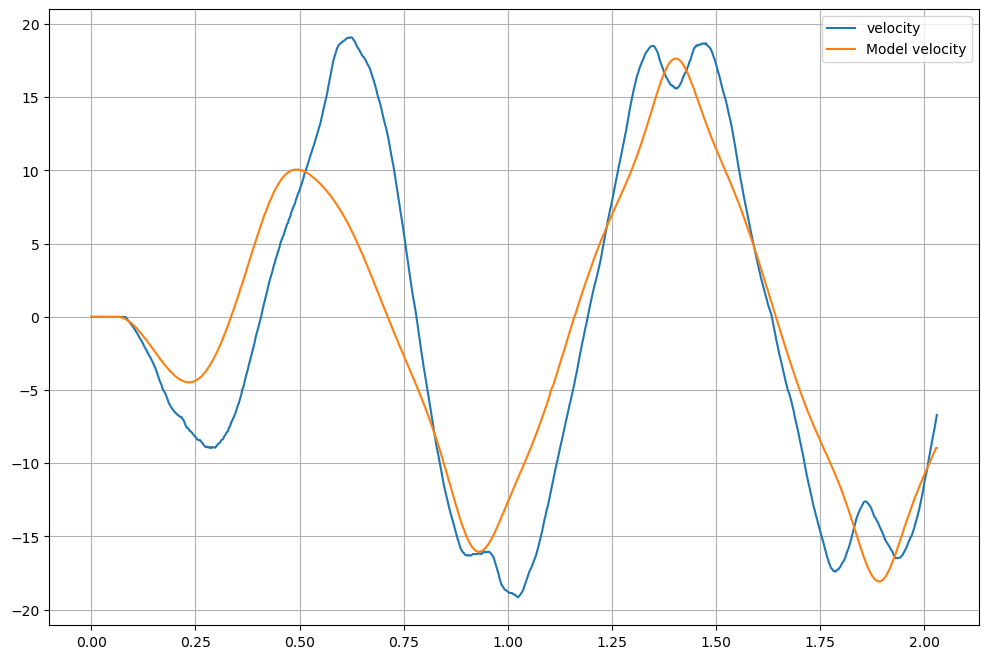

<BarContainer object of 13 artists>

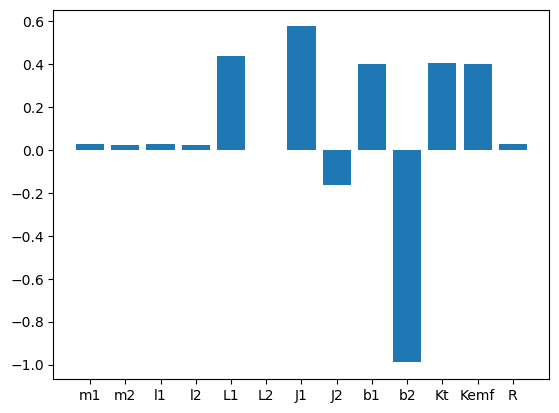

In [39]:
from scipy.optimize import minimize

def create_trajectory_for_opt(timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R):
    return create_trajectory(timestamps, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R])

def objective_function(params, time, real_data):
    simulated_data = create_trajectory_for_opt(time, *params)
    error = np.sum((simulated_data - real_data)**2)
    return error

initial_guess = [m1, l1, J1, b1, Kt, Kemf, R]
# bounds_lower = np.array(initial_guess) * 0.1
# bounds_upper = np.array(initial_guess) * 10.0

min_scale_1 = 0.01
max_scale_1 = 100.0
# min_scale_2 = 0.8
# max_scale_2 = 1.2
min_scale_2 = 0.01
max_scale_2 = 100.0
min_bounds = [
    min_scale_2 * m1,
    min_scale_2 * m2,
    min_scale_2 * l1,
    min_scale_2 * l2,
    min_scale_2 * L1,
    min_scale_2 * L2,
    min_scale_2 * J1,
    min_scale_2 * J2,
    min_scale_1 * b1,
    min_scale_2 * b2,
    min_scale_1 * Kt,
    min_scale_1 * Kemf,
    min_scale_1 * R,
]
max_bounds = [
    max_scale_2 * m1,
    max_scale_2 * m2,
    max_scale_2 * l1,
    max_scale_2 * l2,
    max_scale_2 * L1,
    max_scale_2 * L2,
    max_scale_2 * J1,
    max_scale_2 * J2,
    max_scale_1 * b1,
    max_scale_2 * b2,
    max_scale_1 * Kt,
    max_scale_1 * Kemf,
    max_scale_1 * R,
]

initial_guess = [m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R]

bounds = [(lower, upper) for lower, upper in zip(min_bounds, max_bounds)]

real_data = [[x[1], x[2], x[3], x[4]] for x in dataset]

result = minimize(objective_function, initial_guess, args=(timestamps, real_data), bounds=bounds)
optimized_params = result.x

print("Optimized parameters:", optimized_params)

s = create_trajectory_for_opt(timestamps, *optimized_params)

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i + 1] for x in dataset], label=x_columns[i + 1].split("/")[-1])
    plot(
        timestamps, [x[i] for x in s], label="Model " + x_columns[i + 1].split("/")[-1]
    )
    plt.legend()
    plt.grid(True)
    plt.show()

from matplotlib.pyplot import bar

bar(
    ["m1", "m2", "l1", "l2", "L1", "L2", "J1", "J2", "b1", "b2", "Kt", "Kemf", "R"],
    (optimized_params - initial_guess) / initial_guess,
)


# OLD optimization

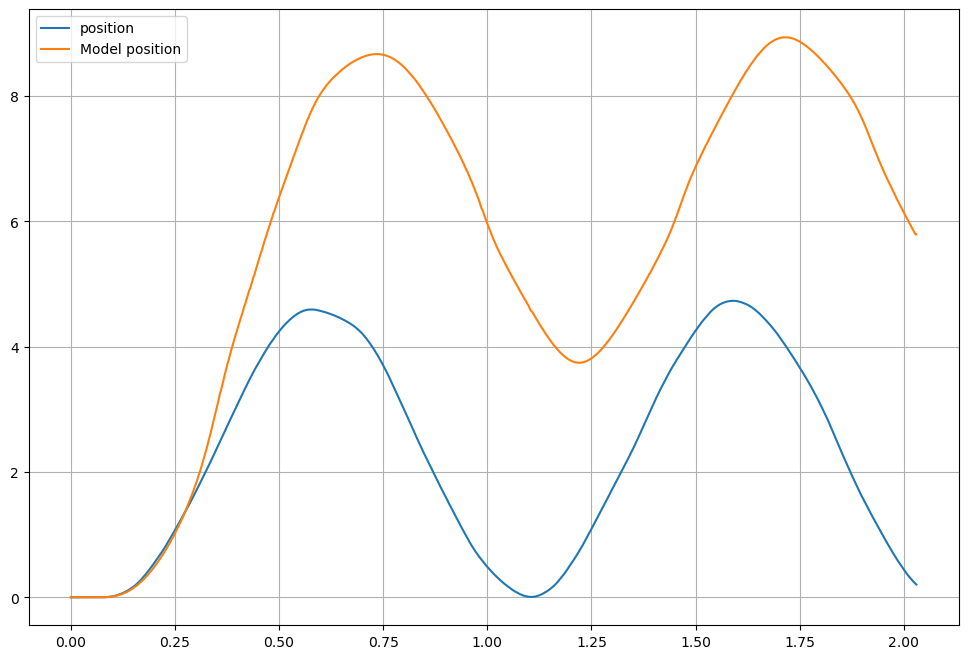

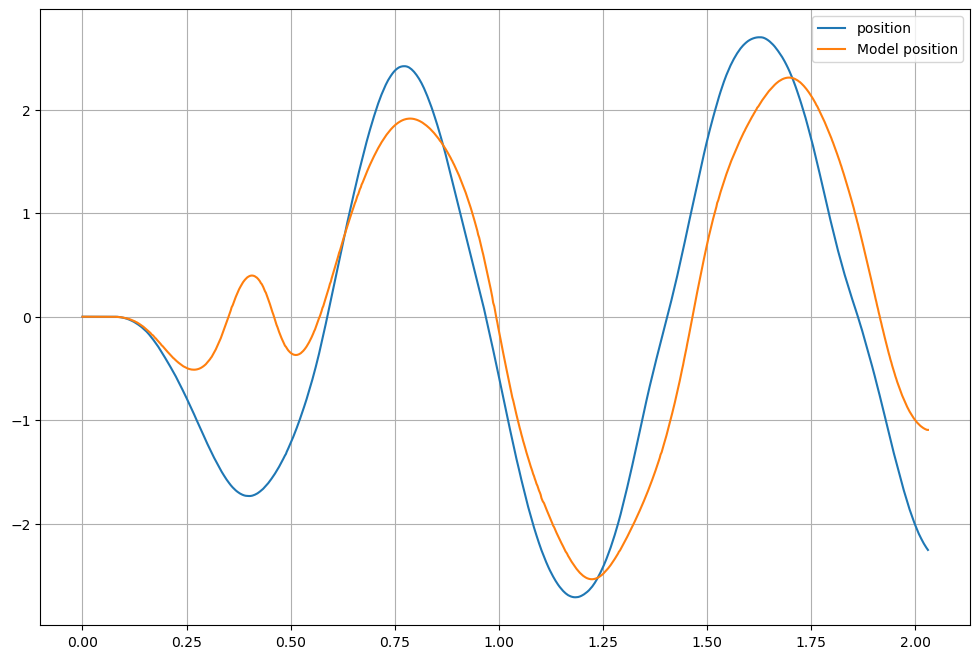

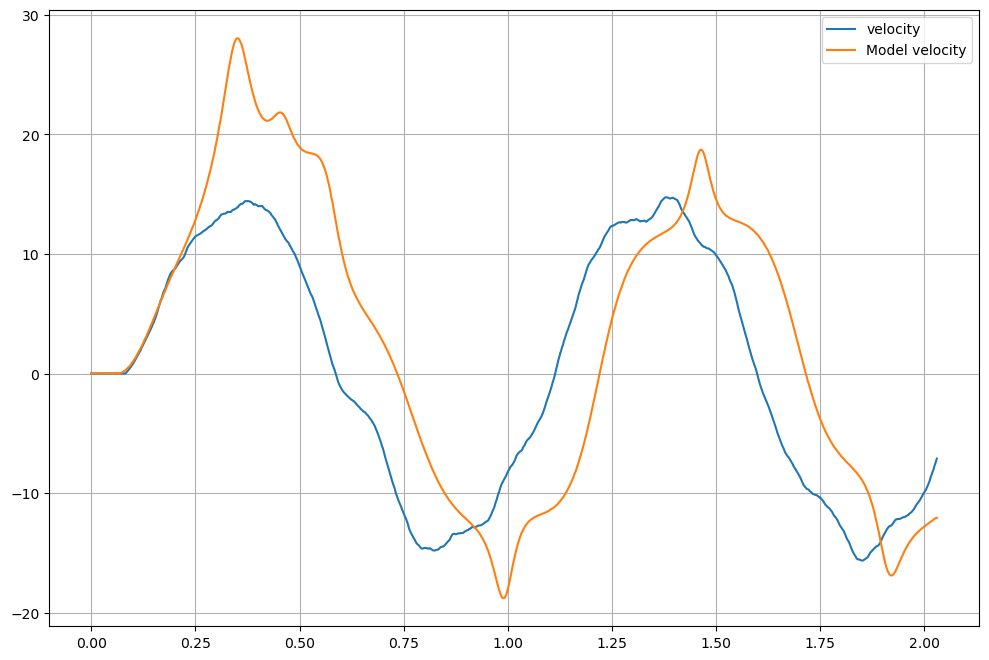

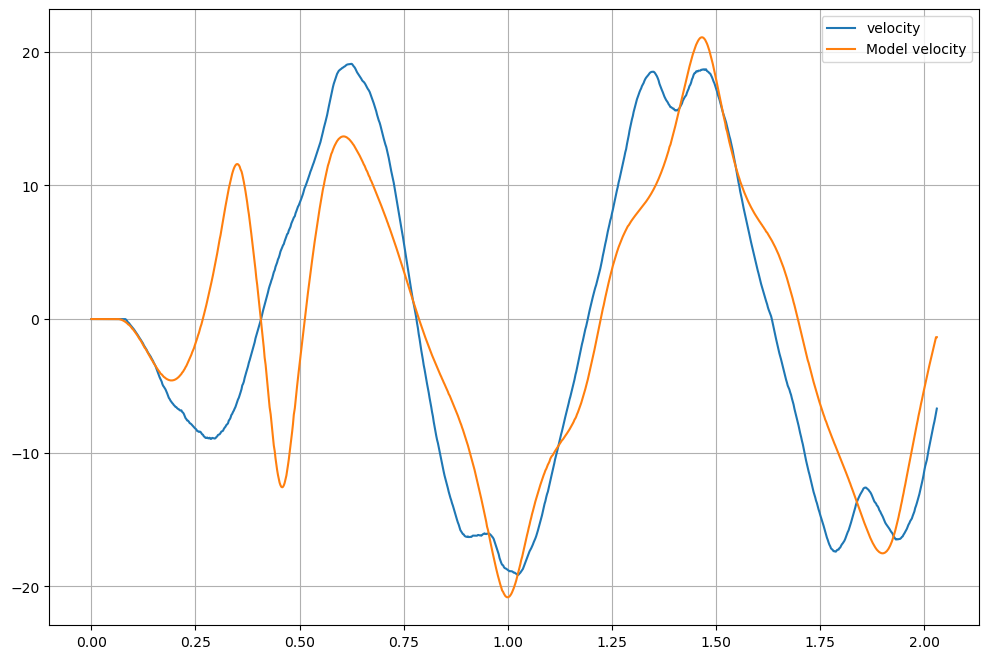

<BarContainer object of 13 artists>

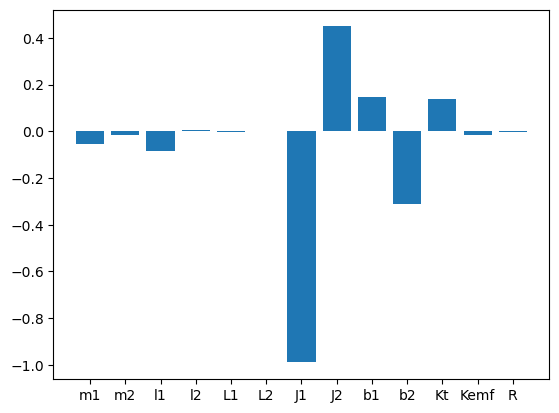

In [11]:
from scipy.optimize import curve_fit

min_scale_1 = 0.01
max_scale_1 = 100.0
min_scale_2 = 0.5
max_scale_2 = 1.5
# min_scale_2 = 0.01
# max_scale_2 = 100.0
min_bounds = [
    min_scale_1 * m1,
    min_scale_2 * m2,
    min_scale_1 * l1,
    min_scale_2 * l2,
    min_scale_2 * L1,
    min_scale_2 * L2,
    min_scale_1 * J1,
    min_scale_2 * J2,
    min_scale_1 * b1,
    min_scale_2 * b2,
    min_scale_1 * Kt,
    min_scale_1 * Kemf,
    min_scale_1 * R,
]
max_bounds = [
    max_scale_1 * m1,
    max_scale_2 * m2,
    max_scale_1 * l1,
    max_scale_2 * l2,
    max_scale_2 * L1,
    max_scale_2 * L2,
    max_scale_1 * J1,
    max_scale_2 * J2,
    max_scale_1 * b1,
    max_scale_2 * b2,
    max_scale_1 * Kt,
    max_scale_1 * Kemf,
    max_scale_1 * R,
]

initial_guess = [m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R]

x_desired = [x[4] for x in dataset]


def create_trajectory_for_opt(
    timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R
):
    return create_trajectory(
        timestamps, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R]
    )


def create_trajectory_j1_pos(
    timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R
):
    traj = create_trajectory_for_opt(
        timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R
    )
    return [x[3] for x in traj]


opt_params, _ = curve_fit(
    create_trajectory_j1_pos,
    timestamps,
    x_desired,
    p0=initial_guess,
    bounds=(min_bounds, max_bounds),
)

s = create_trajectory_for_opt(timestamps, *opt_params)

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i + 1] for x in dataset], label=x_columns[i + 1].split("/")[-1])
    plot(
        timestamps, [x[i] for x in s], label="Model " + x_columns[i + 1].split("/")[-1]
    )
    plt.legend()
    plt.grid(True)
    plt.show()

from matplotlib.pyplot import bar

bar(
    ["m1", "m2", "l1", "l2", "L1", "L2", "J1", "J2", "b1", "b2", "Kt", "Kemf", "R"],
    (opt_params - initial_guess) / initial_guess,
)

# Verify with new data

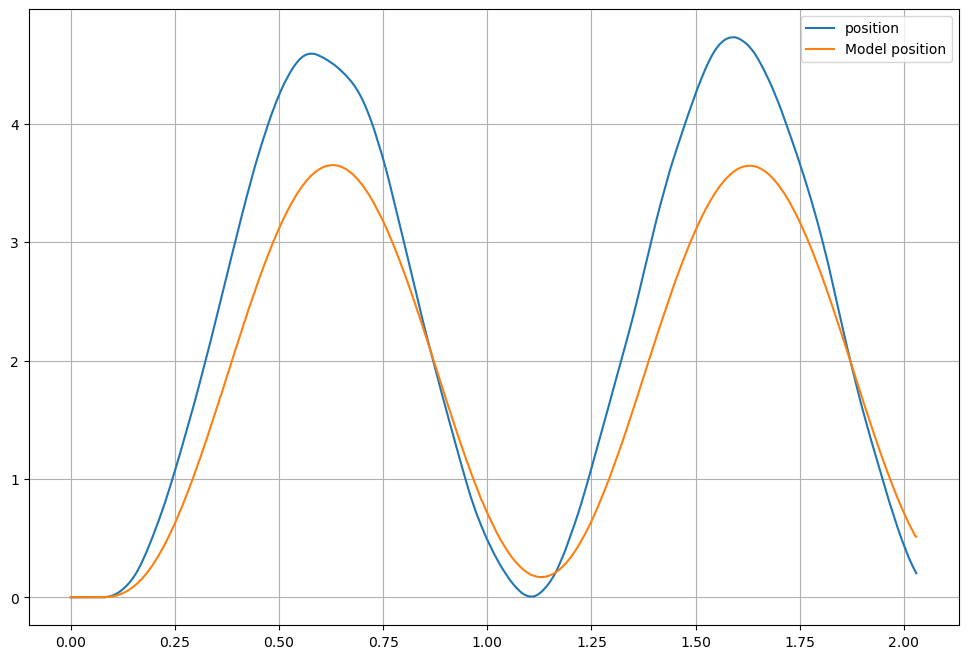

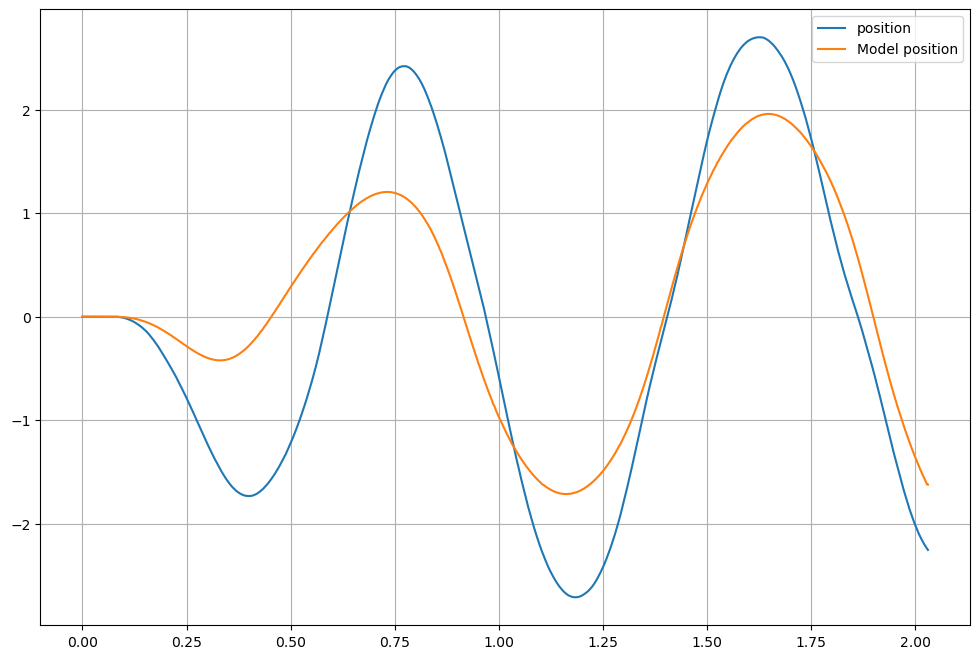

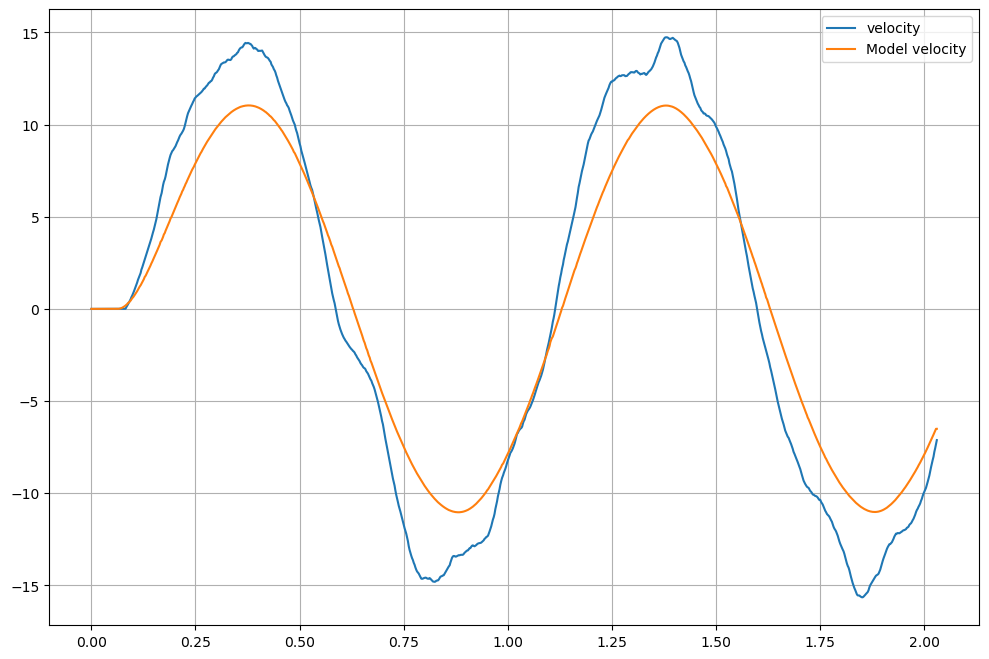

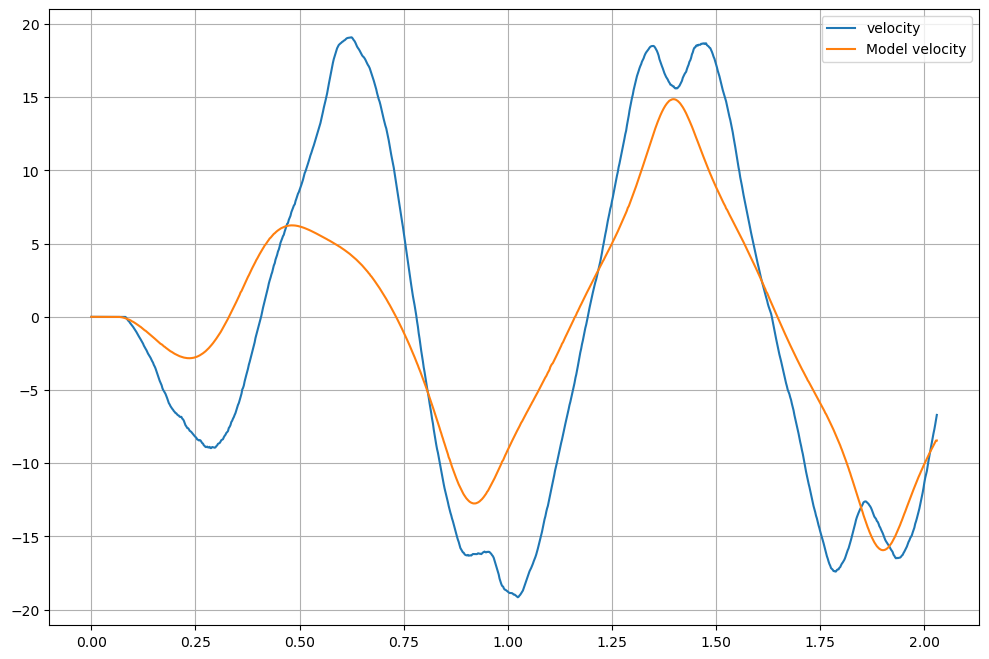

In [31]:
import matplotlib.pyplot as plt

oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data
    "hardware_sin_response_4V_1s.csv",
)
dataset = CustomDataset(oscillations_file, x_columns, starting_idx, ending_idx)
timestamps = [dataset.get_timestamp(idx) for idx in range(len(dataset))]
V_setpoint = [x[0] for x in dataset]


s = create_trajectory(timestamps, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R])


for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i+1] for x in dataset], label=x_columns[i+1].split("/")[-1])
    plot(timestamps, [x[i] for x in s], label="Model " + x_columns[i+1].split("/")[-1])
    plt.legend()
    plt.grid(True)
    plt.show()

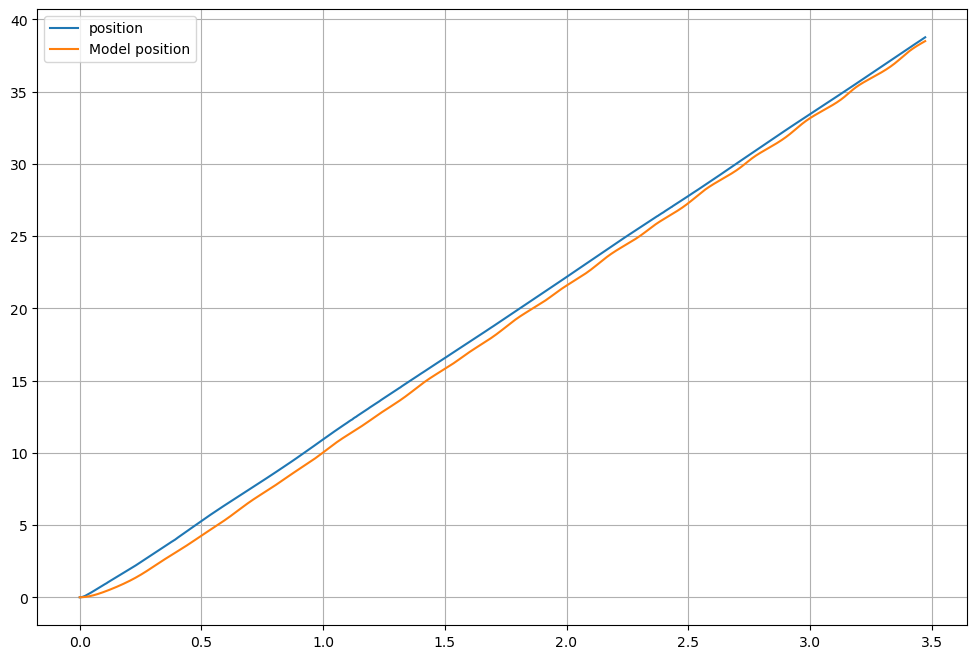

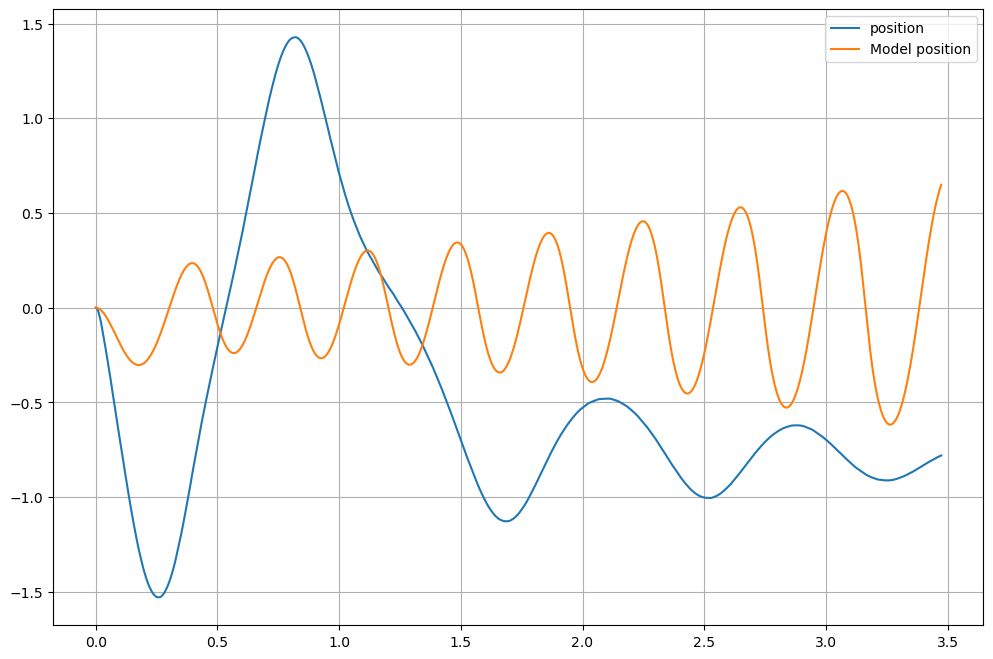

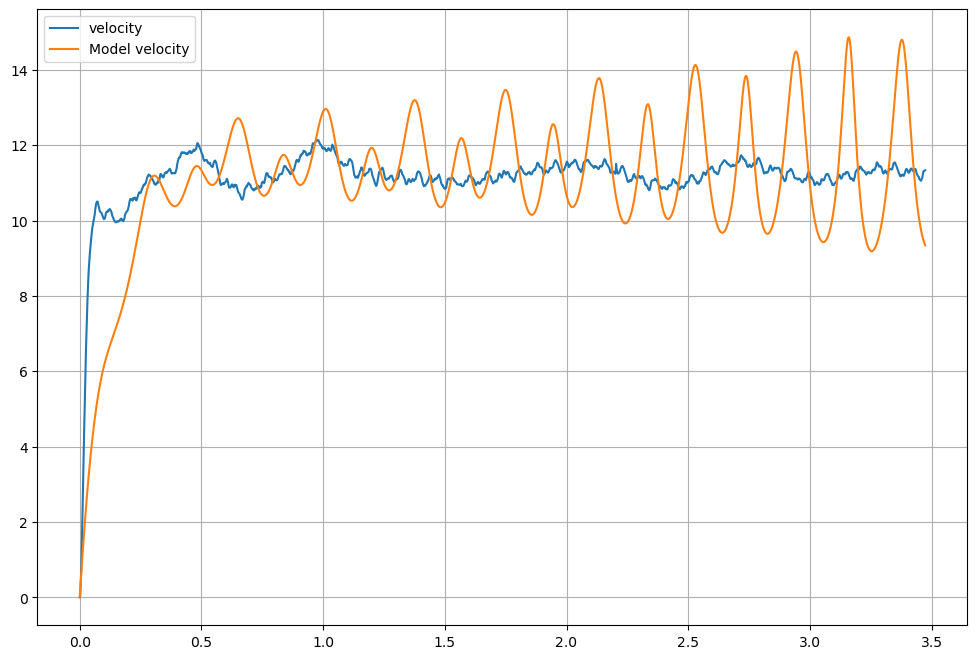

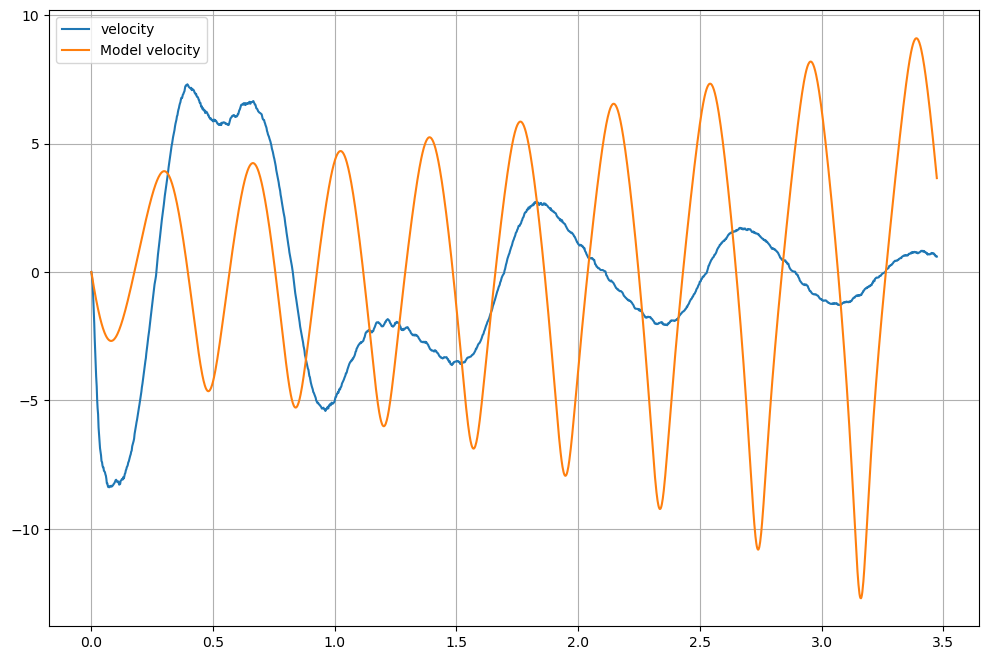

In [159]:
step_response_3V = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_step_response_3V.csv",
)

dataset_step_response_3V = CustomDataset(step_response_3V, x_columns, 118, 2000)

timestamps_step_response_3V = [
    dataset_step_response_3V.get_timestamp(idx)
    for idx in range(len(dataset_step_response_3V))
]

# f_opt = F_opt(*[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R], 3.0)
f_opt = F_opt(*optimized_params, 3.0)
simulated_trajectory_3V = odeint(f_opt, y0=[0, 0, 0, 0], t=timestamps_step_response_3V)

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(
        timestamps_step_response_3V,
        [x[i + 1] for x in dataset_step_response_3V],
        label=x_columns[i + 1].split("/")[-1],
    )
    plot(
        timestamps_step_response_3V,
        [x[i] for x in simulated_trajectory_3V],
        label="Model " + x_columns[i + 1].split("/")[-1],
    )
    plt.legend()
    plt.grid(True)
    plt.show()

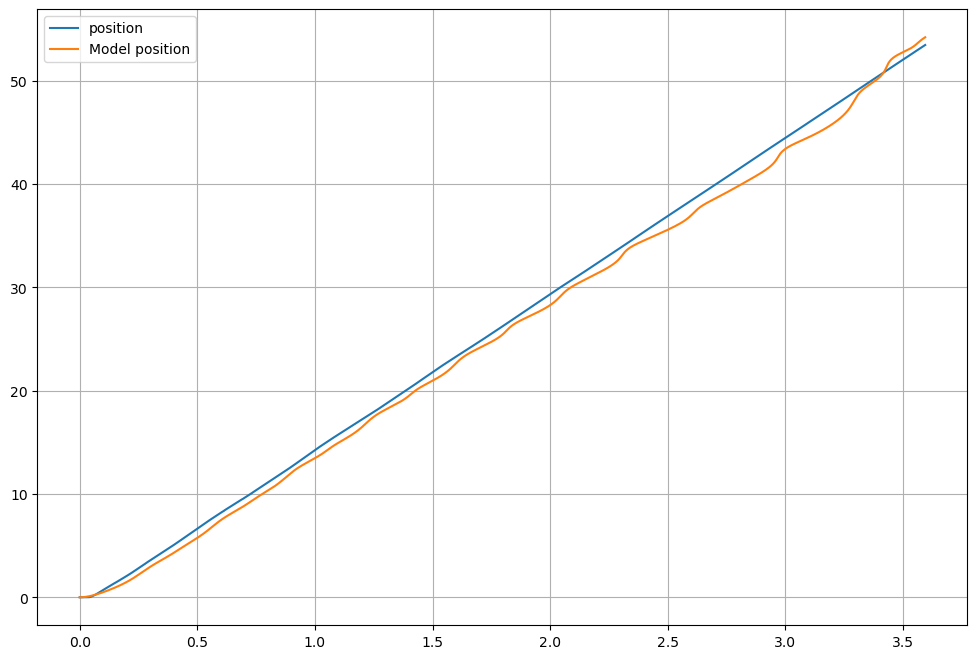

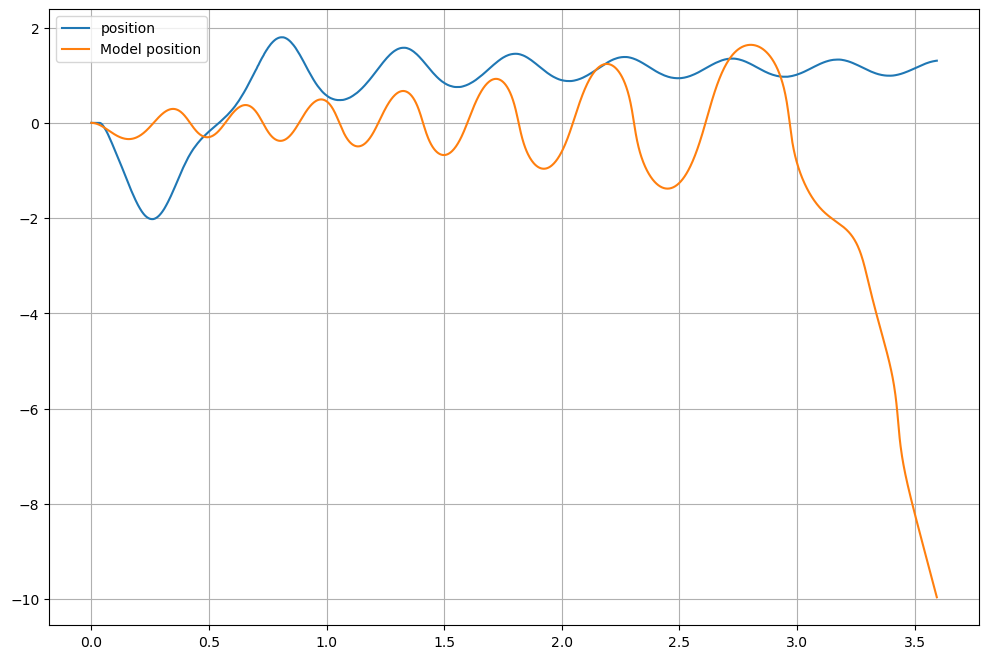

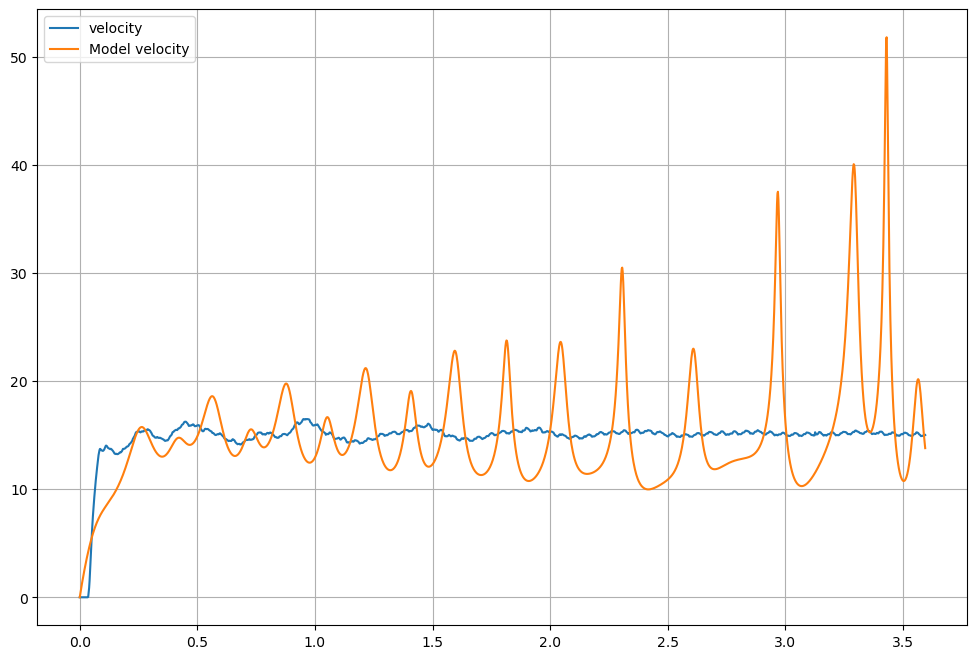

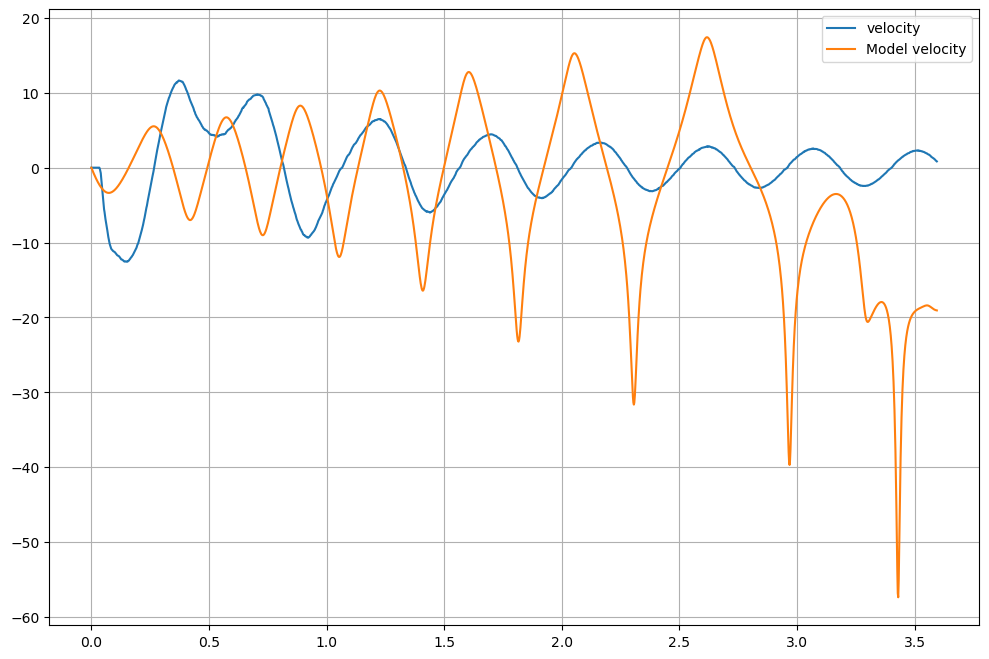

In [161]:
step_response_4V = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_step_response_4V.csv",
)

dataset_step_response_4V = CustomDataset(step_response_4V, x_columns, 200, 2000)

timestamps_step_response_4V = [
    dataset_step_response_4V.get_timestamp(idx)
    for idx in range(len(dataset_step_response_4V))
]

# f_opt = F_opt(*[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R], 4.0)
f_opt = F_opt(*optimized_params, 4.0)
simulated_trajectory_4V = odeint(f_opt, y0=[0, 0, 0, 0], t=timestamps_step_response_4V)

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(
        timestamps_step_response_4V,
        [x[i + 1] for x in dataset_step_response_4V],
        label=x_columns[i + 1].split("/")[-1],
    )
    plot(
        timestamps_step_response_4V,
        [x[i] for x in simulated_trajectory_4V],
        label="Model " + x_columns[i + 1].split("/")[-1],
    )
    plt.legend()
    plt.grid(True)
    plt.show()

# Sinusoid response

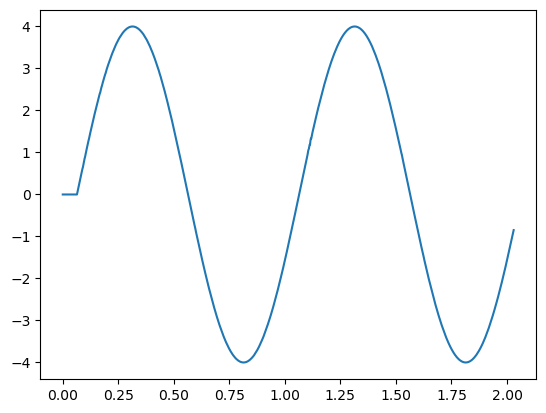

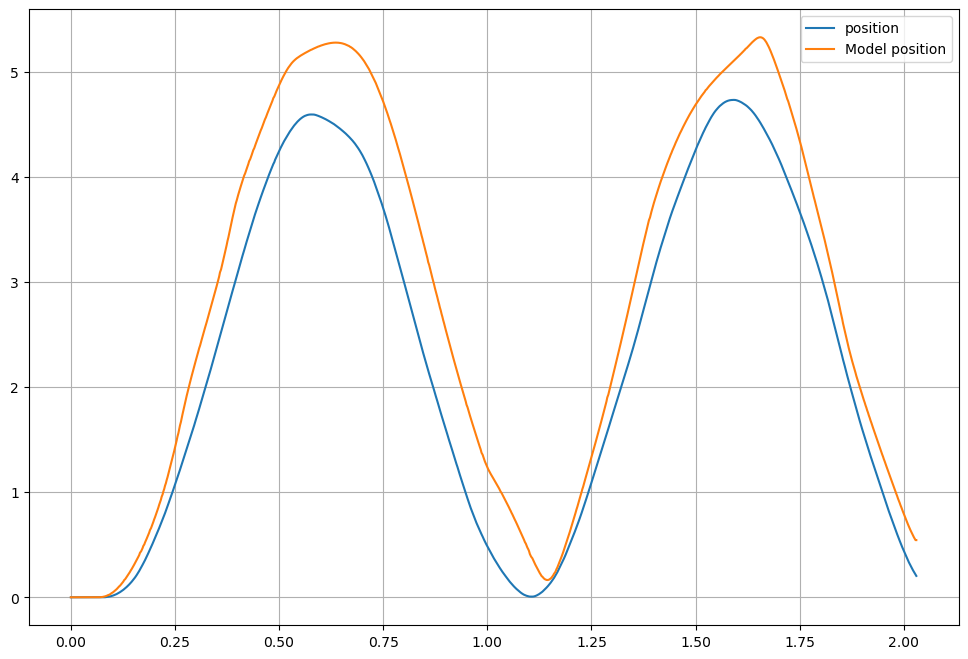

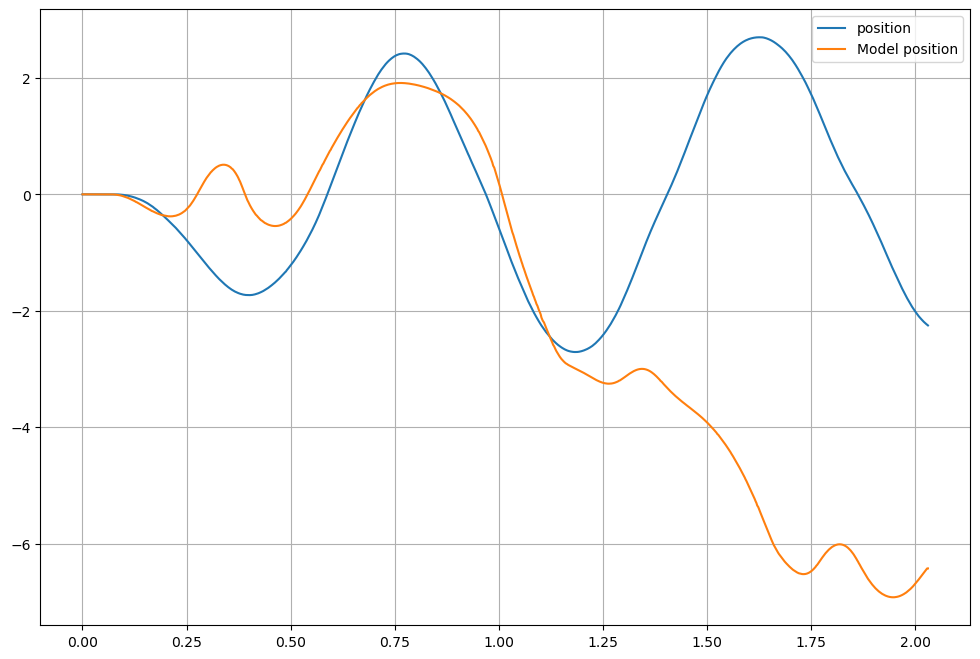

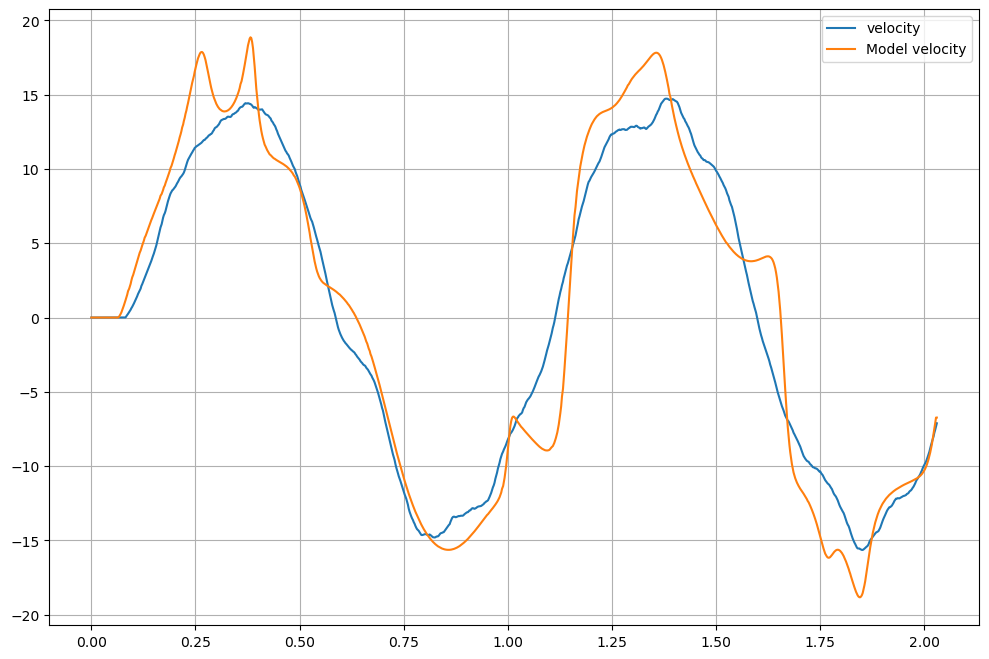

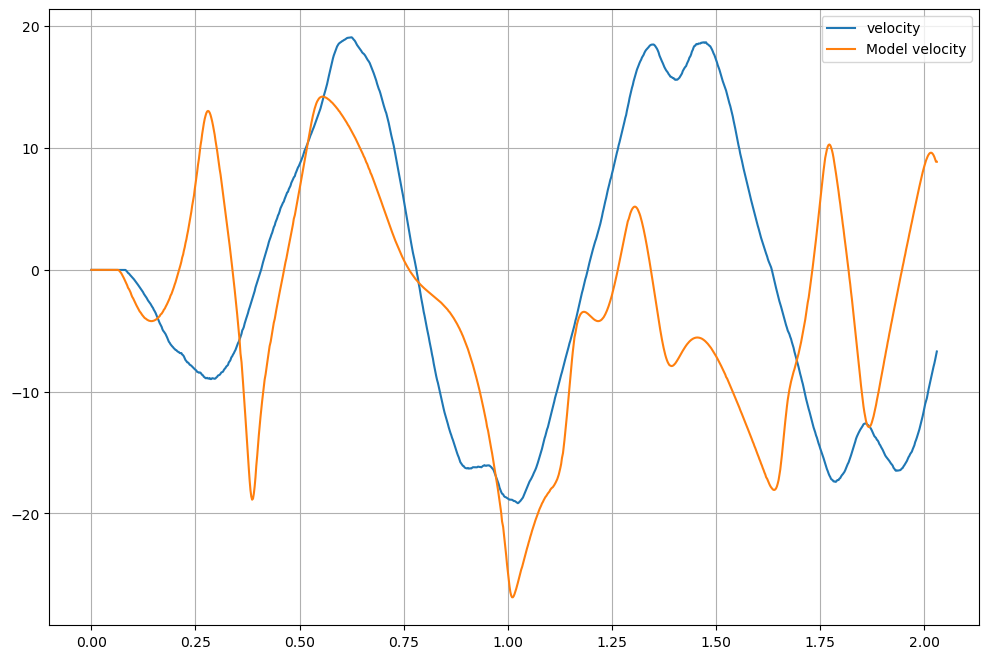

In [234]:
sin_response = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_sin_response_4V_1s.csv",
)

dataset_sin_response = CustomDataset(sin_response, x_columns, 0, 2000)


timestamps_sin_response = [
    dataset_sin_response.get_timestamp(idx) for idx in range(len(dataset_sin_response))
]
V_setpoint_sin_response = [x[0] for x in dataset_sin_response]

plot(timestamps_sin_response, V_setpoint_sin_response)


def create_trajectory(timestamps, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R):
    result = []
    y_previous = [0, 0, 0, 0]
    for i in range(len(timestamps) - 1):
        f_opt = F_opt(
            m1,
            m2,
            l1,
            l2,
            L1,
            L2,
            J1,
            J2,
            b1,
            b2,
            Kt,
            Kemf,
            R,
            V_setpoint_sin_response[i],
        )
        # Integrate from previous time to current time
        t_span = [timestamps[i], timestamps[i + 1]]
        y_integrated = odeint(f_opt, y_previous, t_span)[-1]
        result.append(y_integrated)
        y_previous = y_integrated

    result.append(y_integrated)
    return np.array(result)


# simulated_trajectory_sin_response = create_trajectory(
#     timestamps_sin_response, *optimized_params
# )
simulated_trajectory_sin_response = create_trajectory(
    timestamps_sin_response,
    *[m1 * 0.1, m2, l1, l2, L1, L2, J1 * 0.1, J2, 0.003, b2 * 0.01, 0.1, Kemf, R / 2.0]
)
# simulated_trajectory_sin_response = create_trajectory(
#     timestamps_sin_response,
#     *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2, Kt, Kemf, R]
# )

for i in range(4):
    plt.figure(figsize=(12, 8))
    plot(
        timestamps_sin_response,
        [x[i + 1] for x in dataset_sin_response],
        label=x_columns[i + 1].split("/")[-1],
    )
    plot(
        timestamps_sin_response,
        [x[i] for x in simulated_trajectory_sin_response],
        label="Model " + x_columns[i + 1].split("/")[-1],
    )
    plt.legend()
    plt.grid(True)
    plt.show()